# EAM Copper

In notebook, we will look at two different examples: calculation of melting temperature of Cu, and the temperature-pressure phase diagram of copper. 

The EAM potential we will use is : [Mishin, Y., M. J. Mehl, D. A. Papaconstantopoulos, A. F. Voter, and J. D. Kress. “Structural Stability and Lattice Defects in Copper: Ab Initio , Tight-Binding, and Embedded-Atom Calculations.” Physical Review B 63, no. 22 (May 21, 2001): 224106.](https://doi.org/10.1103/PhysRevB.63.224106)

## Melting temperature

The input files required to calculate the melting temperature at zero pressure is given in the folder `melting_temperature`. The input file is shown here-

```
element: 'Cu'
mass: 63.546
calculations:
- mode: ts 
  temperature: [1200, 1400]
  pressure: [0]
  lattice: [FCC, LQD]
  repeat: [7, 7, 7]
  state: [solid, liquid]
  nsims: 1

md:
  pair_style: eam/alloy
  pair_coeff: "* * /home/examples/Cu_EAM/Cu01.eam.alloy Cu"
  timestep: 0.001
  nsmall: 10000
  tdamp: 0.1
  pdamp: 0.1
  te: 25000
  ts: 50000
  
queue:
  scheduler: local
  cores: 14
  commands:
    - conda activate py3
```

The calculation block gives the input conditions at which the calculation is carried out. First of all, the `mode` is `ts`, a temperature sweep over the temperature range given in the `temperature` keyword will be done. `FCC` and `LQD` lattice are chosen, the former for `solid` and the latter for `liquid`. The potential file is specified in `pair_coeff` command in the `md` block. Please note that the absolute path of the potential file has to be provided. 

The calculation can be run by,
```
cd melting_temperature
tint -i input.yaml
```
Once submitted, it should give a message `Total number of 2 calculations found`. It will also create a set of folders with the names `mode-lattice-temperature-pressure`. In this case, there will be `ts-FCC-1200-0` and `ts-LQD-1200-0`. If there are any errors in the calculation, it will be recoreded in `ts-FCC-1200-0.sub.err` and `ts-LQD-1200-0.sub.err`. Once the calculation starts, a log file called `tint.log` will be created in the aforementioned folders. For example, the `tint.log` file in `ts-FCC-1200-0` is shown below:

```
2021-02-13 14:58:37,853 pytint.helpers INFO     At count 1 mean pressure is 1.195624 with 12.628737 vol/atom
2021-02-13 14:58:44,188 pytint.helpers INFO     At count 2 mean pressure is -0.377718 with 12.629433 vol/atom
2021-02-13 14:58:44,188 pytint.helpers INFO     finalized vol/atom 12.629433 at pressure -0.377718
2021-02-13 14:58:44,188 pytint.helpers INFO     Avg box dimensions x: 25.877000, y: 25.877000, z:25.877000
2021-02-13 14:58:50,588 pytint.helpers INFO     At count 1 mean k is 1.294586 std is 0.050296
2021-02-13 14:58:56,471 pytint.helpers INFO     At count 2 mean k is 1.312711 std is 0.044848
2021-02-13 14:58:56,472 pytint.helpers INFO     finalized sprint constants
2021-02-13 14:58:56,472 pytint.helpers INFO     [1.31]
```

The file gives some information about the preparation stage. It can be seen that at loop 2, the pressure is converged and very close to the 0 value we specified in the input file. After the pressure is converged, box dimensions are fixed, and the spring constants for the Einstein crystal are calculated.  

The `ts` mode consists of two stages, the first step is the calculation of free energy at 1300 K, followed by a sweep until 1400 K. The results of the free energy calculation is recorded in `report.yaml` file. The file is shown below:

```
average:
  spring_constant: '1.31'
  vol/atom: 12.62943343337578
input:
  concentration: '1'
  element: Cu
  lattice: fcc
  pressure: 0.0
  temperature: 1200
results:
  error: 0.0
  free_energy: -4.071022164568864
  pv: 0.0
  reference_system: -0.7488816028733712
  work: -3.3221405616954924
```

In the file, the average and input quantities are recorded. The more interesting block is the `results` block. Here the calculated free energy value in eV/atom is given in the `free_energy` key. The free energy of the reference system is given in `reference_system` and the work done in switching is under `work`. The `error` key gives the error in the calculation. In this case, its 0 as we ran only a single loop (see `nsims`). The `report.yaml` file for liquid looks somewhat similar.

```
average:
  density: 0.07557512575222705
  vol/atom: 13.228440515092743
input:
  concentration: '1'
  element: Cu
  lattice: fcc
  pressure: 0.0
  temperature: 1200
results:
  error: 0.0
  free_energy: -4.058745224019001
  pv: 0.0
  reference_system: 0.6842261808018877
  work: 4.742971404820889
```

The main difference here is that under the `average` block, the `density` is reported instead of `spring_constant`.

The variation of the free energy within the temperature range is given in the `temperature_sweep.dat` files instead of each of the folders. The file contains three columns, temperature, free energy and the error in free energy. The files are read in and plotted below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
st, sfe, sferr = np.loadtxt("melting_temp/ts-FCC-1200-0/temperature_sweep.dat", unpack=True)
lt, lfe, lferr = np.loadtxt("melting_temp/ts-LQD-1200-0/temperature_sweep.dat", unpack=True)

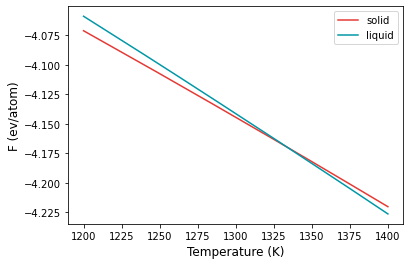

In [6]:
plt.plot(st, sfe, color="#E53935", label="solid")
plt.plot(lt, lfe, color="#0097A7", label="liquid")
plt.xlabel("Temperature (K)", fontsize=12)
plt.ylabel("F (ev/atom)", fontsize=12)
plt.legend()

From the plot, at temperatures below 1300 K, solid is the more stable structure with lower free energy. Around 1325 K, liquid becomes the more stable structure. We can find the temperature at which the free energy of both phases are equal, which is the melting temperature.

In [10]:
args = np.argsort(np.abs(sfe-lfe))
print(st[args[0]], "K")

1333.6846001020688 K


The calculated melting temperature is 1333 K.

## Phase diagram

In the next example, the temperature-pressure phase diagram will be calculated. The input file is available in the `phase_diagram` folder. The input file is also shown below. Compared to the melting temperature calculation, there are 4 entries in the `calculations` block. Since calculations are carried out at a non-zero pressure, `pytint` will automatically pick internal routines that calculate the Gibbs free energy instead of Helmholtz free energy.

```
element: Cu
mass: 63.546
calculations:
- mode: ts 
  temperature: [1600, 1800]
  pressure: [100000]
  lattice: [FCC, LQD]
  repeat: [5, 5, 5]
  state: [solid, liquid]
  nsims: 1
- mode: ts 
  temperature: [2700, 2900]
  pressure: [500000]
  lattice: [FCC, LQD]
  repeat: [5, 5, 5]
  state: [solid, liquid]
  nsims: 1
- mode: ts 
  temperature: [3700, 3900]
  pressure: [1000000]
  lattice: [FCC, LQD]
  repeat: [5, 5, 5]
  state: [solid, liquid]
  nsims: 1
- mode: ts 
  temperature: [4600, 4700]
  pressure: [1500000]
  lattice: [FCC, LQD]
  repeat: [5, 5, 5]
  state: [solid, liquid]
  nsims: 1

md:
  pair_style: eam/alloy
  pair_coeff: "* * /home/users/menonsqr/Repos/pytint/examples/Cu_EAM/Cu01.eam.alloy Cu"
  timestep: 0.001
  nsmall: 10000
  tdamp: 0.1
  pdamp: 0.1
  te: 25000
  ts: 50000
  
queue:
  scheduler: local
  cores: 4
  commands:
    - conda activate py3
```

Similar to the previous example, the calculation can be run using:

```
tint -i input.yaml
```

After the calculations are run, we can read in the results. Two arrays, `temp` and `press` with the input temperature and pressure is created.

In [16]:
temp = [1600, 2700, 3700, 4600]
press = [100000, 500000, 1000000, 1500000]

Now a small loop which goes over each folder and calculates the melting temperature value:

In [35]:
tms = []

for t, p in zip(temp, press):
    sfile =  "phase_diagram/ts-FCC-%d-%d/temperature_sweep.dat"%(t, p)
    lfile =  "phase_diagram/ts-LQD-%d-%d/temperature_sweep.dat"%(t, p)
    t, f, fe = np.loadtxt(sfile, unpack=True)
    t, l, fe = np.loadtxt(lfile, unpack=True)
    args = np.argsort(np.abs(f-l))
    
    tms.append(t[args[0]])

To compare our results, we will use a Simon equation, given by,

$$
T_m(P) = T_{m0}(P/a + 1)^b
$$

We will use reported values for parameters $T_{m0}$, $a$ and $b$ from two different publications:

- [Wang, Shuaichuang, Gongmu Zhang, Haifeng Liu, and Haifeng Song. “Modified Z Method to Calculate Melting Curve by Molecular Dynamics.” The Journal of Chemical Physics 138, no. 13 (April 7, 2013): 134101.](https://doi.org/10.1063/1.4798225)

In [36]:
def get_tm(press):
    tm = 1315*(press/15.84 + 1)**0.543
    return tm

- [An, Qi, Sheng-Nian Luo, Li-Bo Han, Lianqing Zheng, and Oliver Tschauner. “Melting of Cu under Hydrostatic and Shock Wave Loading to High Pressures.” Journal of Physics: Condensed Matter 20, no. 9 (March 5, 2008): 095220.](https://doi.org/10.1088/0953-8984/20/9/095220)

In [37]:
def get_tm2(press):
    tm = 1325*(press/15.37 + 1)**0.53
    return tm

An array for pressures over which the two equations will be fit, and values of the two expressions are calculated.

In [38]:
pfit = np.arange(0, 151, 1)
tma = get_tm(pfit)
tmb = get_tm2(pfit)

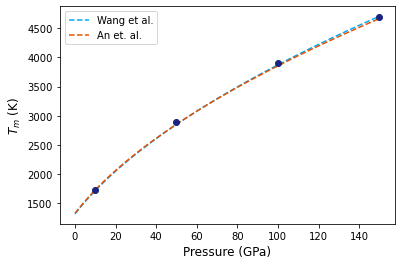

In [44]:
plt.plot(pfit, tma, ls="dashed", label="Wang et al.", color="#03A9F4")
plt.plot(pfit, tmb, ls="dashed", label="An et. al.", color="#E65100")
plt.plot(np.array(press)/10000, tms, 'o', color="#1A237E")
plt.xlabel("Pressure (GPa)", fontsize=12)
plt.ylabel(r"$T_m$ (K)", fontsize=12)
plt.legend()

We can see that the agreement is quite good!